# Projet Fil Rouge 2022 : Reconnaissance de commandes audio
---


**Nom - Prenom :** El Moustaaid Mountassir

**Nom - Prenom :** Minh Vuong




**Objectif** : tester l'algorithme de programmation dynamique vu en CTD et réaliser la mise en oeuvre d'un système de reconnaissance audio de mots isolés (constituant des
commandes pour les drones).

<img src="./DroneJS.jpg" width="600" height="500"  >


- Partie I : Prétraitement des données 
- Partie II : Sélection de variables et pénalisation
- Partie III : Classification par méthodes à noyau 
- Partie IV : Apprentissage par ensemble : Adaboost, gradient boosting
- Partie V : Classification par réseaux de neurones
- Partie VI : Votre étude




In [1]:
import matplotlib.pyplot as plt
from os.path import join
from os import listdir
import librosa
import torch

# fix the random seed
import random
random.seed(0)

# fix the numpy random seed
import numpy as np
np.random.seed(0)

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# import user defined functions
from mfccUtilities import *
from melUtilities import *
from utils import *

# Préparation du jeu de données
---

Sur l'espace moodle de l'ENSEEIHT, nous trouvons un dossier d'enregistrements audio de mots de commandes pour un drone quadricoptère constitués de plusieurs locuteurs masculins (notés M01..M13) et locutrice féminines (F01..F05) pour quelques commandes. 

Les lignes de code suivantes permettent de transformer le fichier audio en matrice de paramètres appélés MFCC (Mel Frequency Cepstral Coefficient) en utilisant la librairie python *librosa*. Ces paramètres permettent d'extraire au mieux le contenu vocal fréquenciel de signal audio.

La matrice de sortie est composée d'autant de vecteurs colonnes que de trames d'analyses. Le nombre de lignes correspond à la dimension du vecteur représentatif : ici 12.



## Prétraitement sur 1 fichier audio

In [2]:
# path to the dataset
datapath = join('.', 'data')

# the first audio file
filename = listdir(datapath)[0]
filepath = join(datapath, filename)

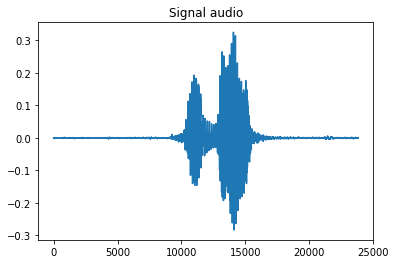

In [3]:
audio, sr = load_audio(filepath)

plot_audio(audio)

**Calcul des MFCC**

Nous constatons que la commande audio n'occupe qu'une portion du signal et que le reste du signal est presque nulle ce qui correspond à un silence.

Ça ne sert à rien d'appliquer la MFCC sur le signal entier, vaut mieux supprimer le silence avant de continuer les calcules.

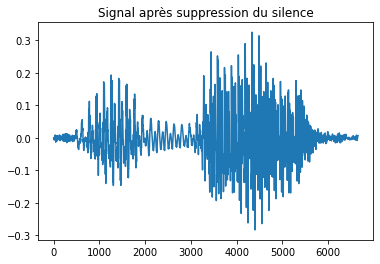

In [4]:
audio, sr = trim((audio, sr))

plot_audio(audio, 'Signal après suppression du silence')

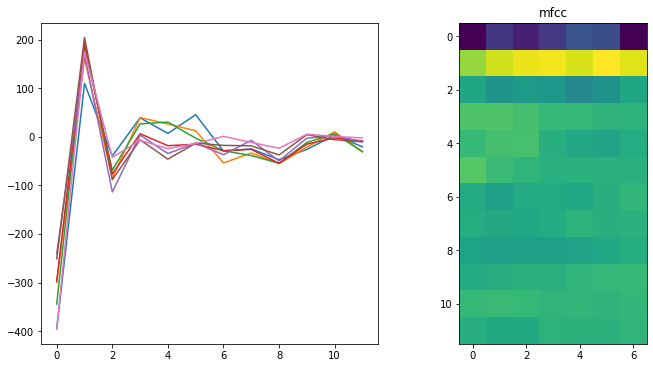

In [5]:
mfcc = compute_mfcc((audio, sr))

plot_mfcc(mfcc)

Puis nous calculons la moyenne et la variance sur chaque fenêtre.

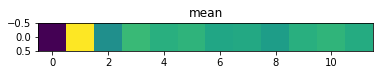

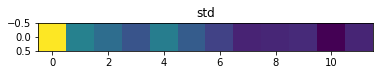

In [6]:
mfcc_mean = compute_mfcc_mean(mfcc)

plt.imshow(mfcc_mean.reshape(-1,1).T)
plt.title('mean')
plt.show()

mfcc_std = compute_mfcc_std(mfcc)
plt.imshow(mfcc_std.reshape(-1,1).T)
plt.title('std')
plt.show()

#### Création de la base d'apprentissage et de test 

Nous allons utilisé tout les enregistrements audio.

Nous avons donc recopié tout les enregistrements dans le même dossier **data**.

Visulisons le nombre de fichier audio par classes.

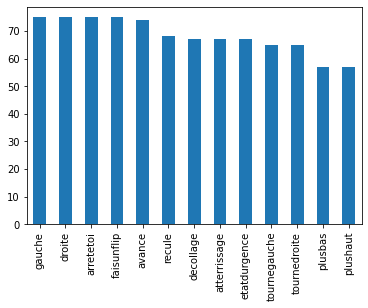

In [7]:
all_classes = bar_plot(datapath)

Dans un premier temps, nous nous limitons à trois classes, notre objectif est de comparer les approches.

Les classes à garder sont :
* avance
* recule
* tournegauche

In [8]:
classes = ['avance','recule', 'gauche']

In [9]:
test_percent = 0.3

BaseApp, BaseTest, LabelApp, LabelTest = \
    load_data(datapath, classes, test_percent, scale = True)

BaseApp_raw, BaseTest_raw, LabelApp_raw, LabelTest_raw = \
    load_data(datapath, classes, test_percent, scale = False)

Appliquons un pipeline de transformations sur le jeu de données.

Dans un premier temps nous supprimons les silences, puis nous transformons le résultat en matrice MFCC, puis nous calculons la moyenne et la variance sur chaque fenêtre de cette matrice.

In [10]:
from sklearn.pipeline import Pipeline, FeatureUnion
from preprocessing import *

avg_std = FeatureUnion([
            ('averageCalculator', MfccAverageCalculator()),
            ('stdCalculator', MfccStdCalculator())
        ])

prep_pipeline = Pipeline([
    ('trimmer', Trimmer()), 
    ('mfcc', Mfcc(n_mfcc= 12)),
    ('avg_std_calculator', avg_std)
    ])

In [11]:
BaseApp = prep_pipeline.transform(BaseApp)
BaseTest = prep_pipeline.transform(BaseTest)

BaseApp_raw = prep_pipeline.transform(BaseApp_raw)
BaseTest_raw = prep_pipeline.transform(BaseTest_raw)

Voyons à quoi ressemble notre jeu de données d'entrainement

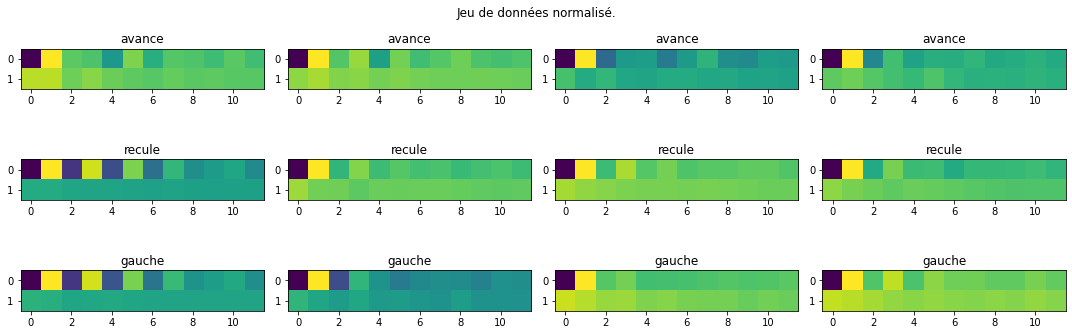

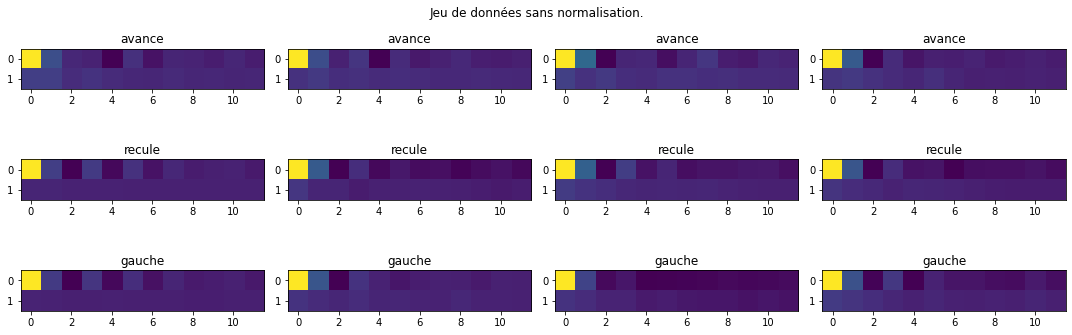

In [12]:
fig = plt.figure(figsize = (15,5))
for label_idx, label_name in enumerate(classes):
    indices = (LabelApp == label_idx)
    dataset = BaseApp[indices]
    for i in range(4):
        data = dataset[i].reshape(2,-1)
        ax = plt.subplot(3, 4, (i+1) + 4*label_idx)
        ax.imshow(data)
        ax.set_title(label_name)
        #ax.set_axis_off()
plt.tight_layout()
fig.suptitle('Jeu de données normalisé.')
plt.show()

fig = plt.figure(figsize = (15,5))
for label_idx, label_name in enumerate(classes):
    indices = (LabelApp == label_idx)
    dataset = BaseApp_raw[indices]
    for i in range(4):
        data = dataset[i].reshape(2,-1)
        ax = plt.subplot(3, 4, (i+1) + 4*label_idx)
        ax.imshow(data)
        ax.set_title(label_name)
        #ax.set_axis_off()
plt.tight_layout()
fig.suptitle('Jeu de données sans normalisation.')
plt.show()

# Partie I : Sélection de modèles et pénalisation

### 1. Régression Multiclasse

Appliquer un modèle de **régression multiclasses**.

On modélise les probabilités par la forme suivante :

$$
\mathbb{P}(Y_i = j) = \frac { \exp^{-\beta_j^{T} X_i } } { 1 + \sum_{\ell = 1}^{K-1} \exp^{-\beta_\ell^{T} X_i }}, 
$$
Pour tout $j$ dans $\{ 1,2, \dots , K-1 \}$.

On peut aussi considérer un modèle binomiale par classe pour l'analyse. i.e (Considérer les labels dans la classe $k$ comme étant 1 et les autres labels 0)

Pour votre étude, On vous proposera les comparaisons suivantes (liste exhaustive) : 

1. Essayer différents type d'optimiseurs disponibles dans la librairie Sklearn (lbfgs, saga, sag, newton-cg) et comparer la vitesse de convergence.

2. Faire varier le coefficient de régularisation $C$ (<span style="color:red"> **Il y a toujours une régularisation par défaut dans sklearn** </span>) et comparer son effet sur la performance.

3. Modèle binomiale versus Régression multinomiale. 

4. Le rescaling des donnés améliore t-il la performance ? 

In [13]:
# Modèle de régression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import itertools

Comparer la performance du modèle avant et après normalisation.

In [14]:
reg = LogisticRegression()
reg.fit(BaseApp, LabelApp)
score = reg.score(BaseTest, LabelTest)

reg = LogisticRegression()
reg.fit(BaseApp_raw, LabelApp_raw)
score_raw = reg.score(BaseTest_raw, LabelTest_raw)

print(f"avant normalisation : {score_raw * 100:.2f}%")
print(f"après normalisation : {score * 100:.2f}%")

avant normalisation : 81.82%
après normalisation : 83.33%


La normalisation du jeu de données augmente la performance.  
Dans la suite, nous allons utiliser le jeu de données normalisé.

In [15]:
# Free memory space
del BaseApp_raw, BaseTest_raw, LabelApp_raw, LabelTest_raw

Determiner le meilleur modèle et l'optimisateur correspondant.

In [16]:
# Create a dictionary of all values we want to test for the solver
solvers = ['lbfgs', 'sag', 'saga', 'newton-cg']
multi_class = ['multinomial', 'ovr']

# Initialize the optimal score
opt_score = 0
opt_params = []

# for each solver and class create and train the model
for solver, multi_class in itertools.product(solvers, multi_class):
    regressor = LogisticRegression(solver = solver, multi_class = multi_class, max_iter= 100_000, random_state = 0)
    regressor = regressor.fit(BaseApp, LabelApp)
    score = regressor.score(BaseTest, LabelTest)
    print(f'test score : {score*100:.2f}%  ==> {multi_class} with solver [{solver}]')
    if score >= opt_score:
        if score > opt_score:
            # if we have a new best score then we need to forget the
            # previous optimal paramters
            opt_params = []
        opt_params.append((multi_class, solver))
        # update the score
        opt_score = score

print('\n')
print("Les meilleurs paramètres sont : ")
for c, solver in opt_params:
    print(f"{c} with solver [{solver}]")

test score : 86.36%  ==> multinomial with solver [lbfgs]
test score : 83.33%  ==> ovr with solver [lbfgs]
test score : 83.33%  ==> multinomial with solver [sag]
test score : 83.33%  ==> ovr with solver [sag]
test score : 83.33%  ==> multinomial with solver [saga]
test score : 83.33%  ==> ovr with solver [saga]
test score : 86.36%  ==> multinomial with solver [newton-cg]
test score : 83.33%  ==> ovr with solver [newton-cg]


Les meilleurs paramètres sont : 
multinomial with solver [lbfgs]
multinomial with solver [newton-cg]


Calculons la vitesse de convergence des differents optimisateurs pour le modèle multinomial.

In [17]:
# Create the model
regressor = LogisticRegression(max_iter= 100_000, multi_class= 'multinomial')
# Create a dictionary of all values we want to test for the solver
solvers = ['newton-cg', 'lbfgs', 'sag', 'saga']
param_grid = {'solver' : solvers}
# Use gridsearch to test all values for solver
regressor_gscv = GridSearchCV(regressor, param_grid, cv=4)
# Fit model to data
regressor_gscv.fit(BaseApp, LabelApp)
# Get the duration of fitting
multinomial_train_time = regressor_gscv.cv_results_['mean_fit_time']

Calculons la vitesse de convergence des differents optimisateurs pour le modèle binomial.

In [18]:
# Create the model
regressor = LogisticRegression(max_iter= 100_000, multi_class= 'ovr')
# Create a dictionary of all values we want to test for the solver
solvers = ['newton-cg', 'lbfgs', 'sag', 'saga']
param_grid = {'solver' : solvers}
# Use gridsearch to test all values
regressor_gscv = GridSearchCV(regressor, param_grid, cv=5)
# Fit model to data
regressor_gscv.fit(BaseApp, LabelApp)
# Get the duration of fitting
binomial_train_time = regressor_gscv.cv_results_['mean_fit_time']

Affichons la vitesse de convergence en fonction de l'optimisateur utilisé.

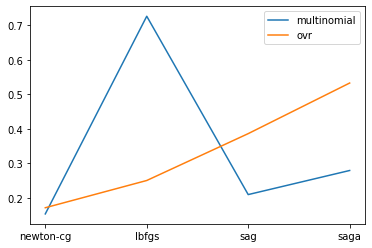

In [19]:
fig = plt.figure()
# Plot training duration
plt.plot(solvers, multinomial_train_time, label = 'multinomial')
plt.plot(solvers, binomial_train_time, label = 'ovr')
# Plot legend and figure
plt.legend()
plt.show()

Dans la suite nous utilisons le modèle multinomial avec le solveur newton-cg, car c'est le plus rapide et c'est l'un des plus précis.

In [20]:
opt_regressor_class = 'multinomial'
opt_regressor_solver = 'newton-cg'

Détérminons le meilleur paramètre C:


In [21]:
C_values = np.linspace(1e-5, 1, 100)

# Initialize the optimal score
opt_score = 0
opt_regressor_C = 0

for C in C_values:
    # Create the model
    regressor = LogisticRegression(C = C, multi_class = opt_regressor_class, solver = opt_regressor_solver, random_state = 0, max_iter= 100_000)

    # Fit model to data
    regressor.fit(BaseApp, LabelApp)
    
    # Get score
    score = regressor.score(BaseTest, LabelTest)
    if score > opt_score:
        opt_score = score
        opt_regressor_C = C

print(f"Le meilleur paramètre C est : {opt_regressor_C:.3f}")

Le meilleur paramètre C est : 0.343


###  Evaluation des résultats 

Evaluer le résultat par matrice de confusion et pourcentage de bonne classification.

*Conseil :* Pensez à mettre une fonction pour afficher la matrice de confusion

In [22]:
# Evaluation des résultats par matrices de confusion 
from sklearn.metrics import accuracy_score

Entrainer les deux modèles : 
* **regressor** : le modèle multinomial avec le solveur sag, mais avec la valeur par defaut du paramètre C
* **opt_regressor** : le modèle multinomial avec le solveur sag et le paramètre C optimale

In [23]:
# le modèle par default
regressor = LogisticRegression(max_iter = 100_000, solver = opt_regressor_solver, multi_class= opt_regressor_class, random_state= 0)
regressor = regressor.fit(BaseApp, LabelApp)

# le modèle optimal
opt_regressor = LogisticRegression(C = opt_regressor_C, max_iter = 100_000, solver = opt_regressor_solver, multi_class= opt_regressor_class, random_state= 0)
opt_regressor = opt_regressor.fit(BaseApp, LabelApp)

In [24]:
pred = regressor.predict(BaseTest)
opt_pred = opt_regressor.predict(BaseTest)
score = accuracy_score(LabelTest, pred)
opt_score = accuracy_score(LabelTest, opt_pred)

print(f"Le score du modèle par defaut est : {score * 100:.2f}%")
print(f"Le score du modèle optimale est : {opt_score * 100:.2f}%")

if opt_score > score:
    print("Le modèle avec les meilleurs paramètre est plus précis que celui implémenté par default.")
elif opt_score == score:
    print("Les deux modèles ont la même precision!!")
else: 
    print("Problème !")

Le score du modèle par defaut est : 86.36%
Le score du modèle optimale est : 87.88%
Le modèle avec les meilleurs paramètre est plus précis que celui implémenté par default.


Nous constatons que le modèle avec les meilleurs paramètre est plus précis que celui implémenté par default par scikit-learn.

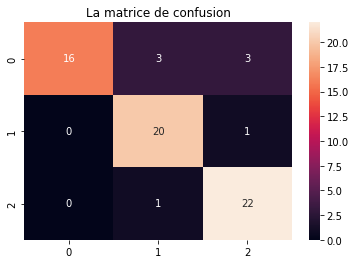

In [25]:
heatmap(LabelTest, opt_pred)


# Partie II : Classification par méthodes à noyau

**Rappel** Les méthodes à noyau consistent à plonger les données dans un espace de dimension de Hilbert $\mathcal{H}$ ou les donnés pourront être séparé linéairement. 

**Theorème de Représentation :** La solution du problème de séparation en dimension infinie est contenue dans un sous espace vectoriel de dimension finie de $\mathcal{H}$ 

### 1. Réaliser une classification par SVM à noyau

    1) Varier le noyau
    2) Varier le paramètre de régularisation.


In [26]:
from sklearn.svm import SVC

Détérminons le meilleur noyau

In [27]:
kernels = ['poly', 'rbf', 'sigmoid', 'linear',]

# Initialize the optimal score
opt_score = 0
opt_kernels = []

for kernel in kernels:
    svm = SVC(kernel= kernel)
    svm.fit(BaseApp, LabelApp)

    score = svm.score(BaseTest, LabelTest)
    print(f"score : {score*100:.2f}% --> kernel : {kernel}")

    if score >= opt_score:
        if score > opt_score:
            opt_kernels = []
        opt_kernels.append(kernel)
        opt_score = score

print("\n")
print(f"les meilleurs noyaux sont : {opt_kernels}")


score : 71.21% --> kernel : poly
score : 71.21% --> kernel : rbf
score : 50.00% --> kernel : sigmoid
score : 78.79% --> kernel : linear


les meilleurs noyaux sont : ['linear']


Nous avons trouvé que le meilleur noyau à utilisé est le noyau linéaire.

Cherchons maintenant le meilleur paramètre C pour le noyau linéaire.

In [28]:
opt_svm_kernel = 'linear'

In [29]:
C_values = np.linspace(1e-5, 1, 50)

# Initialize the optimal score
opt_score = 0
opt_svm_C = 0

for C in C_values:
    svm = SVC(C = C, kernel = opt_svm_kernel)
    svm.fit(BaseApp, LabelApp)

    score = svm.score(BaseTest, LabelTest)

    if score > opt_score:
        opt_score = score
        opt_svm_C = C

print(f"le meilleur paramètre C pour le noyau linéaire est : {opt_svm_C:.3f}")


le meilleur paramètre C pour le noyau linéaire est : 0.020


Comparons les deux modèles : 
* **svm** : le modèle svm linéaire avec le paramètre C par defaut de scikit-learn (C = 1).
* **opt_svm** : le modèle svm linéaire avec le paramètre C optimale qu'on vient de trouver.

In [30]:
# Parameter C by default ( C = 1)
svm = SVC(kernel = opt_svm_kernel)
svm.fit(BaseApp, LabelApp)
score = svm.score(BaseTest, LabelTest)

# Optimal parameter C
opt_svm = SVC(kernel = opt_svm_kernel, C = opt_svm_C)
opt_svm.fit(BaseApp, LabelApp)
opt_score = opt_svm.score(BaseTest, LabelTest)

if opt_score > score : 
    print("La précision du modèle a augmenté avec le paramètre C optimal.")
    print(f"{opt_score*100:.2f}% > {score*100:.2f}%")
elif opt_score == score:
    print("Les deux modèles ont la même précision.")
    print(f"{opt_score*100:.2f}% = {score*100:.2f}%")
else:
    print("Problème!")
    print(f"{opt_score*100:.2f}% < {score*100:.2f}%")

La précision du modèle a augmenté avec le paramètre C optimal.
84.85% > 78.79%


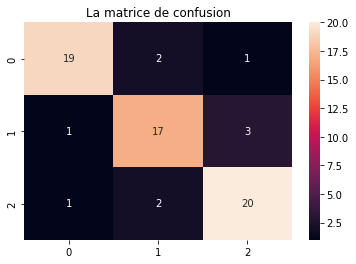

In [31]:
pred = opt_svm.predict(BaseTest)
heatmap(LabelTest, pred)

### Approche non supervisée :  Classification spectrale 

 On peut aussi transposer à l'espace de Hilbert $\mathcal{H}$ des algos classiques de $\mathbb{R}^d$ comme la Classification spectrale.
 
 Réaliser une classification spectrale non supervisée sur les données. Interpréter les résultats 

In [32]:
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA

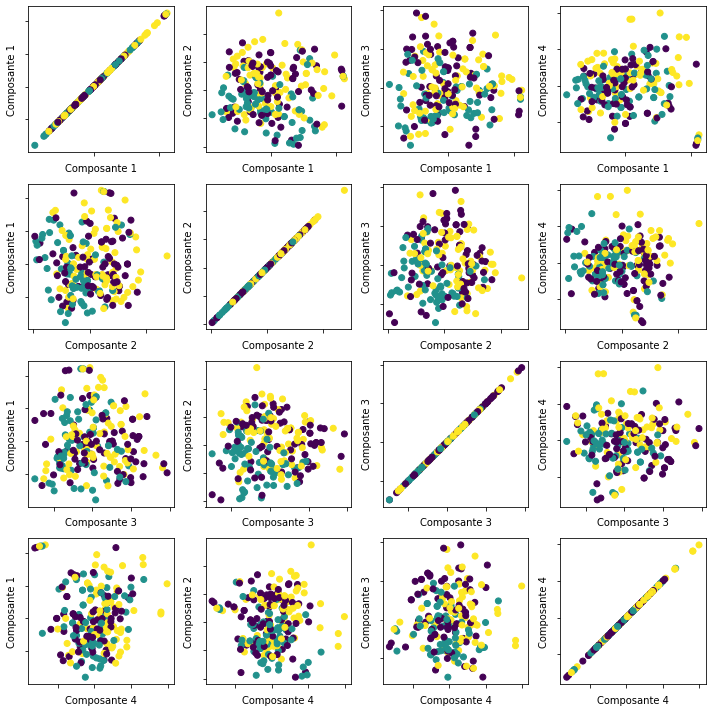

In [33]:
BaseAll = np.concatenate([BaseApp, BaseTest])
LabelAll = np.concatenate([LabelApp, LabelTest])

nb_comp = 4
points = PCA(n_components = nb_comp).fit_transform(BaseAll)

fig = plt.figure(figsize = (10,10))
for comp_1 in range(nb_comp):
    for comp_2 in range(nb_comp):
        ax = plt.subplot(4,4,comp_1 * 4 + comp_2 + 1)
        ax.scatter(points[:, comp_1], points[:, comp_2], c = LabelAll)
        ax.set_xlabel(f'Composante {comp_1 + 1}')
        ax.set_ylabel(f'Composante {comp_2 + 1}')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
plt.tight_layout()
plt.show()


Reduire la dimension et faire le clustering

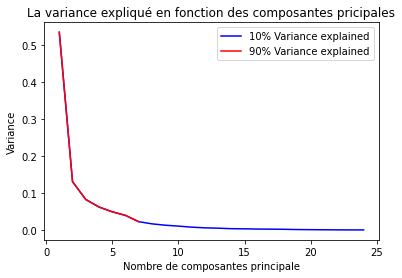

In [34]:
pca = PCA()
pca.fit(BaseAll)
std_ratios = pca.explained_variance_ratio_

acc_std_ratios = np.cumsum(std_ratios)
n_comp = 1 + np.argmax(acc_std_ratios > 0.90)

x_axis = np.arange(1, len(std_ratios)+1, 1)
plt.plot(x_axis, std_ratios, c = 'blue', label = '10% Variance explained')
plt.plot(x_axis[:n_comp], std_ratios[:n_comp], c = 'red', label = '90% Variance explained')
plt.xlabel('Nombre de composantes principale')
plt.ylabel('Variance')
plt.title('La variance expliqué en fonction des composantes pricipales')
plt.legend()
plt.show()

In [35]:
BaseAll = np.concatenate([BaseApp, BaseTest])
LabelAll = np.concatenate([LabelApp, LabelTest])

BaseAll = PCA(n_components = n_comp).fit_transform(BaseAll)

clustering = SpectralClustering(n_clusters=len(classes), random_state= 0)
clustering.fit(BaseAll)

y_pred =  clustering.labels_
score = accuracy_score(y_pred, LabelAll)
print(f"Le score du clustering est : {score* 100:.2f}%")

Le score du clustering est : 35.02%


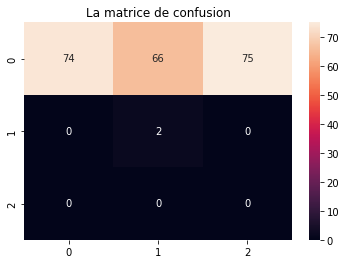

In [36]:
heatmap(y_pred, LabelAll)

# Partie III : Apprentissage par ensemble 

## 1. Adaptive Boosting : AdaBoost 

Adaboost repose sur la sélection itérative de classifieur faible en fonction d'une distribution des exemples d'apprentissage. Chaque exemple est pondéré en fonction de sa difficulté avec le classifieur courant. 

Réaliser une classification par adaboost et étudier 

In [37]:
from sklearn.ensemble import AdaBoostClassifier

In [38]:
# The regression model
opt_regressor = LogisticRegression(C = opt_regressor_C, solver= opt_regressor_solver, multi_class= opt_regressor_class)
opt_regressor.fit(BaseApp, LabelApp)
score = opt_regressor.score(BaseTest, LabelTest)

# Adaboost
opt_score = 0
opt_n_estimators = 0
for i in range(1,50):
    clf = AdaBoostClassifier(base_estimator= opt_regressor ,n_estimators=i, random_state=0)
    clf.fit(BaseApp, LabelApp)
    ada_score = clf.score(BaseTest, LabelTest)
    if ada_score > opt_score:
        opt_score = ada_score
        opt_n_estimators = i

# opt_n_estimators = 270
clf = AdaBoostClassifier(base_estimator= opt_regressor ,n_estimators=opt_n_estimators, random_state=0)
clf.fit(BaseApp, LabelApp)
ada_score = clf.score(BaseTest, LabelTest)

if ada_score > score : 
    print("AdaBoost a augmenté la précision du modèle de regression logistique.")
    print(f"{ada_score*100:.2f}% > {score*100:.2f}%")
elif ada_score == score:
    print("Les deux modèles ont la même précision.")
    print(f"{ada_score*100:.2f}% = {score*100:.2f}%")
else:
    print("AdaBoost a diminué la performance du modèle de regression logistique!")
    print(f"{ada_score*100:.2f}% < {score*100:.2f}%")

In [ ]:
# The regression model
opt_svm = SVC(C = opt_svm_C, kernel = opt_svm_kernel)
opt_svm.fit(BaseApp, LabelApp)
score = opt_svm.score(BaseTest, LabelTest)

# Adaboost
opt_score = 0
opt_n_estimators = 0
for i in range(1,50):
    clf = AdaBoostClassifier(base_estimator= opt_svm ,n_estimators=i, algorithm = 'SAMME', random_state=0)
    clf.fit(BaseApp, LabelApp)
    ada_score = clf.score(BaseTest, LabelTest)
    if ada_score > opt_score:
        opt_score = ada_score
        opt_n_estimators = i

# opt_n_estimators = 
clf = AdaBoostClassifier(base_estimator= opt_svm, algorithm='SAMME', n_estimators=opt_n_estimators, random_state=0)
clf.fit(BaseApp, LabelApp)
ada_score = clf.score(BaseTest, LabelTest)

if ada_score > score : 
    print("AdaBoost a augmenté la précision du modèle SVC.")
    print(f"{ada_score*100:.2f}% > {score*100:.2f}%")
elif ada_score == score:
    print("Les deux modèles ont la même précision.")
    print(f"{ada_score*100:.2f}% = {score*100:.2f}%")
else:
    print("AdaBoost a diminué la performance du modèle SVC!")
    print(f"{ada_score*100:.2f}% < {score*100:.2f}%")

AdaBoost a augmenté la précision du modèle SVC.
87.88% > 84.85%


## 2. Gradient Boosting

Le Gradient Boosting permet l'optimisation de fonctions de perte différentiables arbitraires. Il permet d'optimiser la fonction de perte de l'apprenant précédent en ajoutant un nouveau modèle adaptatif qui combine des apprenants faibles.

Etudier sur la fonction de perte et le taux d'apprentissage.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold


In [ ]:
n_estimators_values = list(range(50,100))
lerning_rate_values = np.linspace(0.01, 1, 10)

stratified_folds = []

skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(BaseAll, LabelAll):
    train_fold, test_fold = BaseAll[train_index], BaseAll[test_index]
    train_fold_labels, test_fold_labels = LabelAll[train_index], LabelAll[test_index]
    stratified_folds.append(
        {
            "train_fold": train_fold,
            "train_fold_labels": train_fold_labels,
            "test_fold": test_fold,
            "test_fold_labels": test_fold_labels
        }
    )


opt_score = 0
counter = 1
for n_estimators, lr in itertools.product(n_estimators_values, lerning_rate_values):
    scores = []
    for fold in stratified_folds:
        train_fold, train_fold_labels = fold['train_fold'], fold['train_fold_labels']
        test_fold, test_fold_labels = fold['test_fold'], fold['test_fold_labels']
        clf = GradientBoostingClassifier(n_estimators=n_estimators, 
                                        learning_rate=lr,
                                        max_depth=1).fit(train_fold, train_fold_labels)
        score = clf.score(test_fold, test_fold_labels)
        scores.append(score)
    
    mean_score = np.mean(scores)
    if mean_score > opt_score:
        opt_score = mean_score
        opt_n_estimators = n_estimators
        opt_lr = lr
        print(f"new optimal score : {mean_score*100:.2f}%")
        print(f"number of estimators : {opt_n_estimators}")
        print(f"learning rate : {opt_lr}")
        print()



new optimal score : 61.28%
number of estimators : 50
learning rate : 0.01

new optimal score : 72.34%
number of estimators : 50
learning rate : 0.12

new optimal score : 74.19%
number of estimators : 50
learning rate : 0.23

new optimal score : 74.63%
number of estimators : 51
learning rate : 0.67

new optimal score : 74.64%
number of estimators : 60
learning rate : 0.23

new optimal score : 75.11%
number of estimators : 61
learning rate : 0.23

new optimal score : 75.57%
number of estimators : 63
learning rate : 0.23



### Evaluation de la classification

Utiliser la validation croisée pour évaluer les résultats 

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
clf = GradientBoostingClassifier(n_estimators=opt_n_estimators, 
                                        learning_rate=opt_lr,
                                        max_depth=1)

scores = cross_val_score(clf, BaseAll, LabelAll, cv = 5)
score = np.mean(scores)

print(f"le score obtenu est : {score*100:.2f}%")

NameError: name 'opt_lr' is not defined

# Partie IV : Classification par réseaux de neurones

1. Réaliser une classification via les réseaux de neurones
2. Evaluer les résultats par matrice de confusion par exemple, fonction de perte...
3. Tester différentes architectures et différents solveurs

In [ ]:
from sklearn.neural_network import MLPClassifier

score : 74.24%


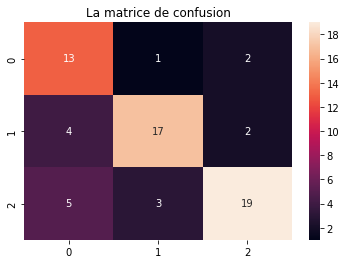

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=0,
                    learning_rate = 'adaptive',
                    max_iter=100_000_000).fit(BaseApp, LabelApp)

score = clf.score(BaseTest, LabelTest)
y_pred = clf.predict(BaseTest)
print(f"score : {score*100:.2f}%")
heatmap(y_pred, LabelTest)


A partir des résultats de cette étude, nous constatons que les meilleurs modèles sont : 
* Regression logistique 
* MLP

Utilisons ces deux modèles, mais cette fois-ci sur le jeu de données entier

In [ ]:
BaseApp, BaseTest, LabelApp, LabelTest = load_data(datapath, all_classes, test_percent, scale = True)

BaseApp = prep_pipeline.transform(BaseApp)
BaseTest = prep_pipeline.transform(BaseTest)

Regression Logistique

Le score est :  53.93%


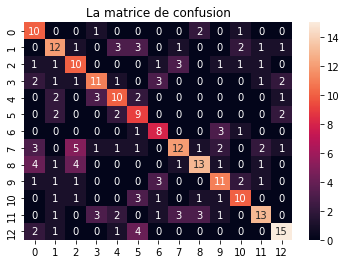

In [ ]:
opt_regressor = LogisticRegression(C = opt_regressor_C, max_iter = 100_000, solver = opt_regressor_solver, multi_class= opt_regressor_class, random_state= 0)
opt_regressor.fit(BaseApp, LabelApp)
score = opt_regressor.score(BaseTest, LabelTest)

print(f"Le score est : {score * 100 : .2f}%")

y_pred = opt_regressor.predict(BaseTest)
heatmap(y_pred, LabelTest)
del opt_regressor

Le score est :  54.68%


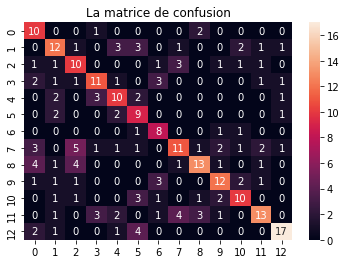

In [ ]:
activation_values = ['identity', 'logistic', 'tanh', 'relu']
solver_values = ['lbfgs', 'adam', 'sgd']
alpha_values = np.linspace(1e-4, 5, 50)

opt_score = 0
for activation, solver in itertools.product(activation_values, solver_values):
#for activation in activation_values:
    clf = MLPClassifier(activation = activation, 
                        solver = solver,
                        random_state=0, 
                        learning_rate = 'adaptive', 
                        max_iter=100_000_000).fit(BaseApp, LabelApp)

    score = clf.score(BaseTest, LabelTest)
    if score > opt_score:
        opt_score = score
        opt_activation = activation
        opt_solver = solver


opt_score = 0
for alpha in alpha_values:
    clf = MLPClassifier(activation = opt_activation, 
                        solver = opt_solver, 
                        alpha = alpha, 
                        random_state=0, 
                        learning_rate = 'adaptive', 
                        max_iter=100_000_000).fit(BaseApp, LabelApp)
    score = clf.score(BaseTest, LabelTest)
    if score > opt_score:
        opt_score = score
        opt_alpha = alpha

opt_MLP = MLPClassifier(activation = opt_activation,
                        solver = opt_solver, 
                        alpha = opt_alpha, 
                        random_state=0, 
                        learning_rate = 'adaptive',
                        max_iter=100_000_000)

opt_MLP = opt_MLP.fit(BaseApp, LabelApp)
score = opt_MLP.score(BaseTest, LabelTest)
print(f"Le score est : {score * 100 : .2f}%")

y_pred = opt_MLP.predict(BaseTest)
heatmap(y_pred, LabelTest)

# Partie V : Votre étude 




Réalisez votre propre étude par binôme :
- en modifiant les bases de test et/ou d'apprentissage c'est-à-dire en créant  votre propre base d'apprentissage et votre base de test à partir du corpus et des voix et bruits que vous aurez enregistrés
- en rajoutant davantage de classes (jusqu'à 13 ordres vocaux disponibles) 
- en utilisant d'autres méthodes de réduction de dimension des MFCC (ACP,t-SNE)
le tout en testant les différentes approches et en interprétant les résultats, à synthétiser sur un rapport en pdf. 


**Paramètres pour enregistrements audio de vos voix perso:**

16 KHz, mono, 16 bits, format *.wav*

En faisant de la data augmentation, nous allons créer un plus grand jeu de données dans lequels :

* Nous supprimons les silences du début et de la fin de chaque fichier.
* Nous ajoutons du bruit gaussien au signal complet.
* Nous allons augmenter ou reduire le volume du signal complet.

Implémentons une fonction pour écouter les fichiers audio sur jupyter.

In [ ]:
import IPython, json
def read_audio(audio, sr):
    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return IPython.display.HTML("""
            <script>
                if (!window.audioContext) {
                    window.audioContext = new AudioContext();
                    window.playAudio = function(audioChannels, sr) {
                        const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                        for (let [channel, data] of audioChannels.entries()) {
                            buffer.copyToChannel(Float32Array.from(data), channel);
                        }
                
                        const source = audioContext.createBufferSource();
                        source.buffer = buffer;
                        source.connect(audioContext.destination);
                        source.start();
                    }
                }
            </script>
            <button onclick="playAudio(%s, %s)">Listen to audio!</button>
        """ % (json.dumps(channels), sr))


### Transformations sur un seul fichier

##### Supprimer le silence au début et à la fin du fichier audio

avant le trim: 
duration :  1.08


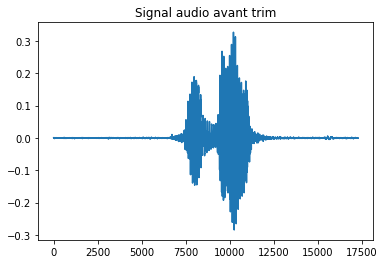

In [ ]:
audio, sr = open(filepath)
print("avant le trim: ")
print("duration : ", librosa.get_duration(audio, sr = sr))
plot_audio(audio, fig_title = "Signal audio avant trim")
read_audio(audio, sr)

après le trim: 
duration :  0.352


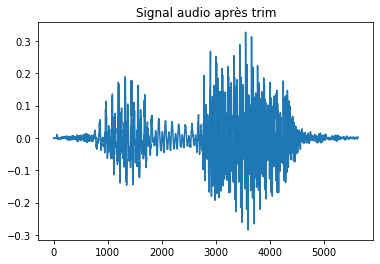

In [ ]:
audio, sr = open(filepath)
audio, sr = trim((audio, sr))
print("après le trim: ")
print("duration : ", librosa.get_duration(audio, sr = sr))
plot_audio(audio, fig_title = "Signal audio après trim")
read_audio(audio, sr)


##### Ajouter du bruit gaussien au signal complet.

avant l'ajout du bruit gausien : 


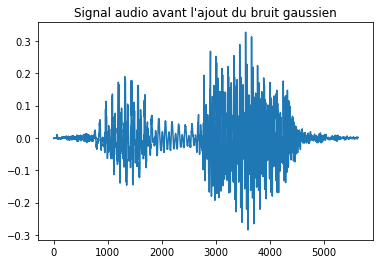

In [ ]:
audio, sr = open(filepath)
audio, sr = trim((audio, sr))

print("avant l'ajout du bruit gausien : ")
plot_audio(audio, fig_title = "Signal audio avant l'ajout du bruit gaussien")
read_audio(audio, sr)

après l'ajout du bruit gausien : 


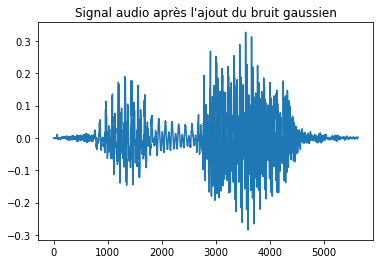

In [ ]:
audio, sr = open(filepath)
audio, sr = trim((audio, sr))
audio, sr = add_noise((audio, sr))

print("après l'ajout du bruit gausien : ")
plot_audio(audio, fig_title = "Signal audio après l'ajout du bruit gaussien")
read_audio(audio, sr)


##### Changer (augmenter ou reduire) le volume du signal.

avant le changement du volume : 


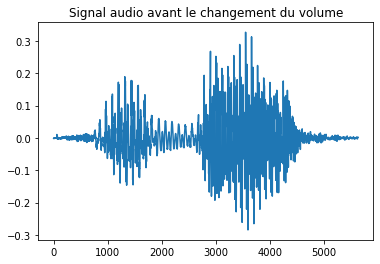

In [ ]:
audio, sr = open(filepath)
audio, sr = trim((audio, sr))

print("avant le changement du volume : ")
plot_audio(audio, fig_title = "Signal audio avant le changement du volume")
read_audio(audio, sr)

après le changement du volume : 


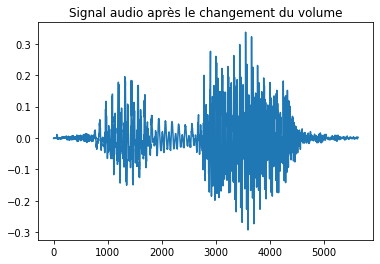

In [ ]:
audio, sr = open(filepath)
audio, sr = trim((audio, sr))
audio, sr = change_volume((audio, sr))

print("après le changement du volume : ")
plot_audio(audio, fig_title = "Signal audio après le changement du volume")
read_audio(audio, sr)

##### Suppression de la fin du fichier audio

Avant trancature : 


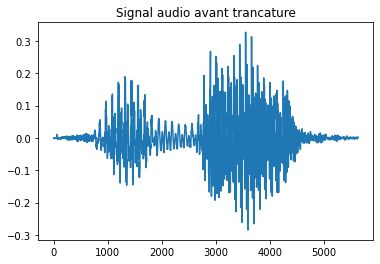

In [ ]:
audio, sr = open(filepath)
audio, sr = trim((audio, sr))

print("Avant trancature : ")
plot_audio(audio, fig_title = "Signal audio avant trancature")
read_audio(audio, sr)

Après trancature : 


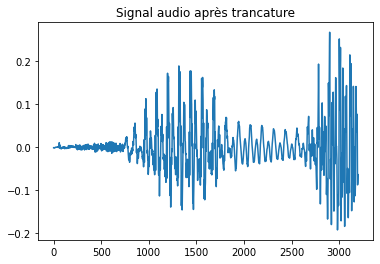

In [ ]:
audio, sr = open(filepath)
audio, sr = trim((audio, sr))
audio, sr = pad_trunc((audio, sr), 200)

print("Après trancature : ")
plot_audio(audio, fig_title = "Signal audio après trancature")
read_audio(audio, sr)


##### Translation temporelle (horizontale)

Avant shift : 


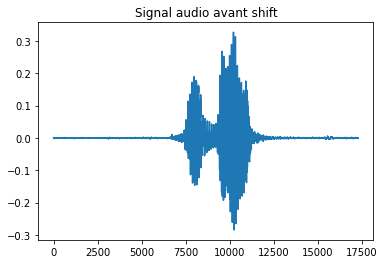

In [ ]:
audio, sr = open(filepath)

print("Avant shift : ")
plot_audio(audio, fig_title = "Signal audio avant shift")
read_audio(audio, sr)

Avant shift : 


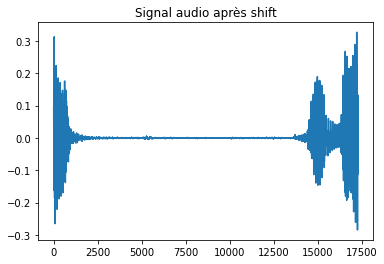

In [ ]:
audio, sr = open(filepath)
audio, sr = time_shift((audio, sr), 1)

print("Avant shift : ")
plot_audio(audio, fig_title = "Signal audio après shift")
read_audio(audio, sr)

##### Transformer en spectre MEL

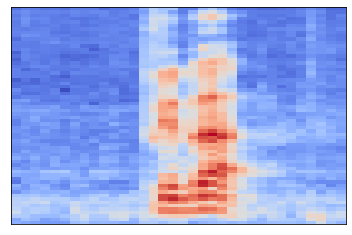

In [ ]:
import librosa.display

audio, sr = open(filepath)
spec = spectro_gram((audio, sr))
librosa.display.specshow(np.squeeze(spec.numpy()))
plt.show()

##### Masquer des bandes temporelle et frequentiel du spectre

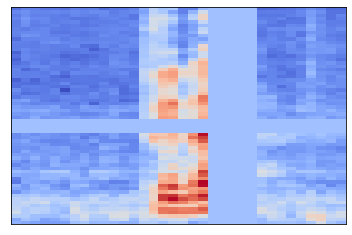

In [ ]:
audio, sr = open(filepath)
spec = spectro_gram((audio, sr))
spec = spectro_augment(spec, max_mask_pct= 0.2)
librosa.display.specshow(np.squeeze(spec.numpy()))
plt.show()

In [ ]:
from dataset import DroneDS

train_df, test_df = stratified_split(datapath, keep_classes = all_classes)

train_ds = DroneDS(train_df, train = True)
test_ds = DroneDS(test_df, train = False)

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
from model import AudioClassifier

# Create the model and put it on the GPU if available
model = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from engine import *

num_epochs = 200
loss_list, acc_list = training(model, train_dl, num_epochs)
torch.save(model, "model.pth")

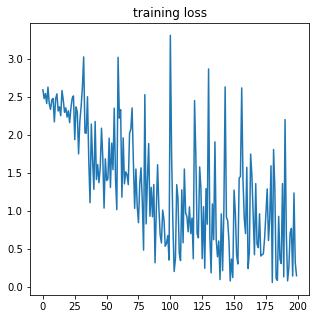

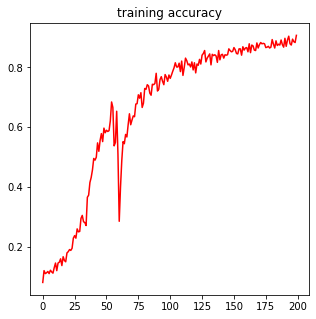

In [ ]:
fig = plt.figure(figsize = (5,5))
plt.plot(loss_list)
plt.title('training loss')
plt.show()

fig = plt.figure(figsize = (5,5))
plt.plot(acc_list, c = 'red')
plt.title("training accuracy")
plt.show()

Accuracy: 7.87, Total items: 178


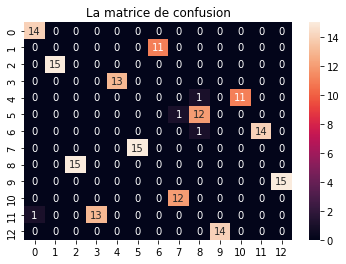

In [67]:
model = torch.load("model_final_without_pca.pth")
def inference(model, val_dl):
  correct_prediction = 0
  total_prediction = 0
  y_pred = []
  y = []


  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)
      y.extend(labels)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      y_pred.extend(prediction)

      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc*100:.2f}, Total items: {total_prediction}')
  heatmap(y_pred, y)

# Run inference on trained model with the validation set
inference(model, test_dl)

### Réduction de la MFCC avec PCA

In [ ]:
from dataset import DroneDS

train_df, test_df = stratified_split(datapath, keep_classes = all_classes)

train_ds = DroneDS(train_df, train = True, pca_comp = 10)
test_ds = DroneDS(test_df, train = False, pca_comp = 10)

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
from model import AudioClassifier

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)

from engine import *

num_epochs = 200
loss_list, acc_list = training(myModel, train_dl, num_epochs)
torch.save(myModel, "model.pth")

Epoch: 1, Loss: 2.59, Accuracy: 0.08, Trigger: 0
Epoch: 2, Loss: 2.56, Accuracy: 0.08, Trigger: 0
Epoch: 3, Loss: 2.50, Accuracy: 0.14, Trigger: 0
Epoch: 4, Loss: 2.48, Accuracy: 0.15, Trigger: 0
Epoch: 5, Loss: 2.43, Accuracy: 0.16, Trigger: 0
Epoch: 6, Loss: 2.40, Accuracy: 0.17, Trigger: 0
Epoch: 7, Loss: 2.40, Accuracy: 0.18, Trigger: 0
Epoch: 8, Loss: 2.35, Accuracy: 0.18, Trigger: 0
Epoch: 9, Loss: 2.34, Accuracy: 0.22, Trigger: 0
Epoch: 10, Loss: 2.27, Accuracy: 0.23, Trigger: 0
Epoch: 11, Loss: 2.28, Accuracy: 0.24, Trigger: 0
Epoch: 12, Loss: 2.16, Accuracy: 0.28, Trigger: 0
Epoch: 13, Loss: 2.16, Accuracy: 0.27, Trigger: 1
Epoch: 14, Loss: 2.11, Accuracy: 0.28, Trigger: 2
Epoch: 15, Loss: 2.06, Accuracy: 0.30, Trigger: 0
Epoch: 16, Loss: 2.02, Accuracy: 0.32, Trigger: 0
Epoch: 17, Loss: 2.03, Accuracy: 0.33, Trigger: 0
Epoch: 18, Loss: 1.93, Accuracy: 0.35, Trigger: 0
Epoch: 19, Loss: 1.92, Accuracy: 0.36, Trigger: 0
Epoch: 20, Loss: 1.97, Accuracy: 0.36, Trigger: 1
Epoch: 21

KeyboardInterrupt: 